In [3]:
import pandas as pd
import matplotlib.pyplot as plt

DataGeneration loads the data from:

https://data.open-power-system-data.org/time_series/ 

From this website the years 2015-2020 (2020 only includes data points from 1st of January - 30th of September) are downloaded.
For each hour in a given year the load demand, solar profile, wind profile on and offshore are downloaded for Denmark (DK1 and DK2), Germany and Norway

# Der er ikke noget data for wind_profile og solar_profile for DK og NO, så jeg har taget det fra capacity, og divideret med maks kapaciteten

In [8]:
from DataGeneration import DataGeneration

# Get the data for a certain year 
year = 2019
region = 'DK_1'

DK1_data = DataGeneration(year = year, region = region).data


# Task A

In [ ]:
import pypsa
import pandas as pd

technology_data = {'gas': {'Marginal_cost': 21.6, 'Efficiency': 0.39, 'Capital_cost': 560000, 'Lifetime': 25, 'CO2_emissions': 0.19},
                   'onshorewind': {'Marginal_cost': 21.6, 'Efficiency': 0.39, 'Capital_cost': 560000, 'Lifetime': 25, 'CO2_emissions': 0.19},
                   'Solar': {'Marginal_cost': 21.6, 'Efficiency': 0.39, 'Capital_cost': 560000, 'Lifetime': 25, 'CO2_emissions': 0.19},
             }

class BuildBaseNetwork:
    def __init__(self, year: int = 2019, profile_data = pd.DataFrame, technology_data = dict, interest_rate = 0.07):
        
        self.year = year

        self.profile_data = profile_data
        self.technology_data = technology_data
        self.interest_rate = interest_rate

        self.network = pypsa.Network()
        self.hours_in_year = pd.date_range(f'{year}-01-01 00:00', f'{year}-12-31 23:00', freq='h')
        self.network.set_snapshots(self.hours_in_year.values)

        self.add_busses()

        self.network.optimize(solver_name='gurobi')

    def add_busses(self):
        self.network.add("Bus", 'electricity bus')
        self.network.add("Load", 'load', bus = 'electricity bus', p_set = self.profile_data['DK_load_actual_entsoe_transparency'].values)
        # add the different carriers, only gas emits CO2


        # self.network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
        self.network.add("Carrier", "gas", co2_emissions = self.technology_data['gas']['CO2_emissions'])
        # add OCGT (Open Cycle Gas Turbine) generator
        capital_cost_OCGT = self.annuity(25, self.interest_rate)*560000*(1+0.033) # in €/MW
        fuel_cost = 21.6 # in €/MWh_th
        efficiency = 0.39 # MWh_elec/MWh_th
        marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
        
        self.network.add("Generator",
                    "OCGT",
                    bus="electricity bus",
                    p_nom_extendable=True,
                    carrier="gas",
                    #p_nom_max=1000,
                    capital_cost = capital_cost_OCGT,
                    marginal_cost = marginal_cost_OCGT)

        self.network.add("Carrier", "onshorewind")
        # add onshore wind generator
        CF_wind = self.profile_data['DK_wind_onshore_generation_actual'].values
        capital_cost_onshorewind = self.annuity(30, self.interest_rate) * self.technology_data['onshorewind']['Capital_cost'] * (1+0.033) # in €/MW
        self.network.add("Generator",
                    "onshorewind",
                    bus="electricity bus",
                    p_nom_extendable=True,
                    carrier="onshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_onshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind)

        self.network.add("Carrier", "solar")

        # add solar PV generator
        CF_solar = self.profile_data['DK_solar_generation_actual'].values
        capital_cost_solar = self.annuity(25,0.07)*425000*(1+0.03) # in €/MW
        self.network.add("Generator",
                    "solar",
                    bus="electricity bus",
                    p_nom_extendable=True,
                    carrier="solar",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_solar,
                    marginal_cost = 0,
                    p_max_pu = CF_solar)

    def add_line(self, name, bus0, bus1, length, s_nom):
        self.network.add("Line", name, bus0, bus1, length=length, s_nom=s_nom)

    @staticmethod
    def annuity(n, r):
        """ Calculate the annuity factor for an asset with lifetime n years and
        discount rate  r """

        if r > 0:
            return r/(1. - 1./(1.+r)**n)
        else:
            return 1/n


In [7]:
technology_data['onshorewind']['Capital_cost']



560000

Det er noteret at:

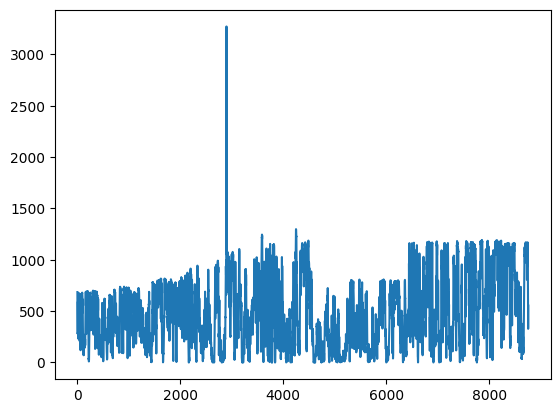

In [19]:
plt.plot(DataGeneration(year = 2019, region = 'DK_1').data['wind_offshore_generation_actual'].values)
plt.show()


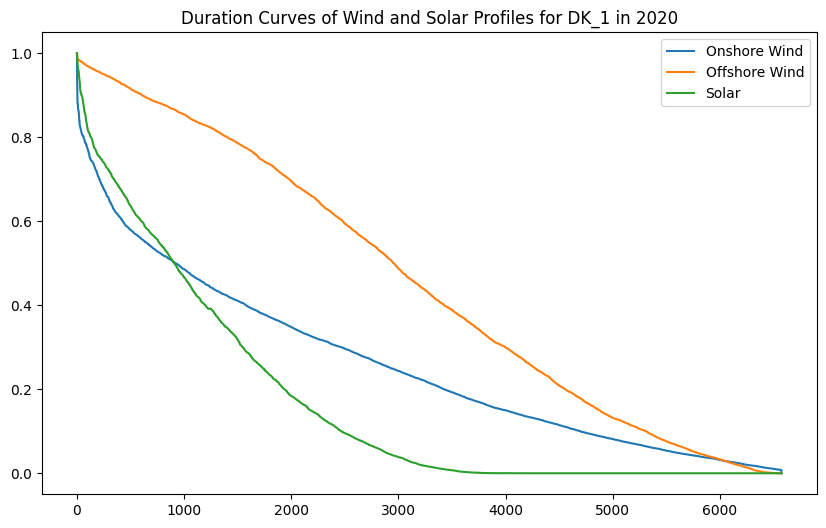

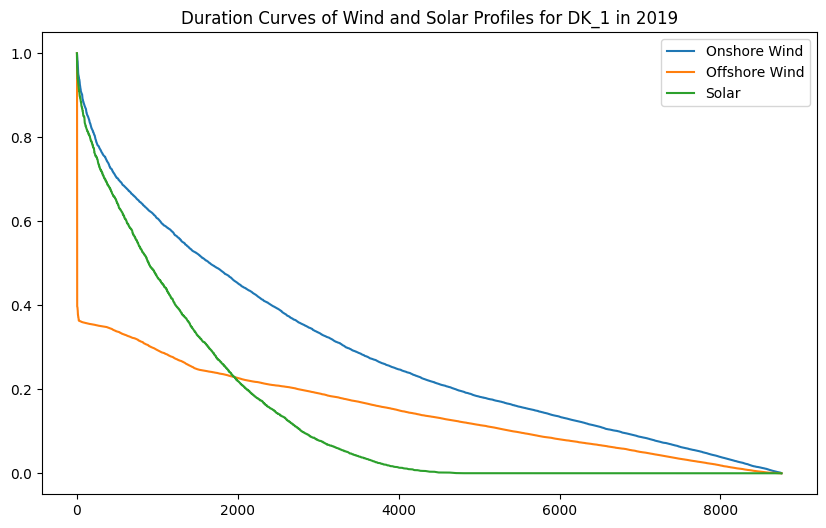

In [ ]:
from DurationCurve import DurationCurve

# region = 'DK_1'
region = 'DK_2'
# region = 'NO'
# region = 'DE'

years = [2017, 2018, 2019, 2020]

DurationCurve(year = year, region = region)
DurationCurve(year = 2019, region = region)
plt.show()